In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import mymysql
import pandas as pd
rc('font',**{'family':'sans-serif',})
labelsize=12
ticksize=12
legendsize=10

simulations = [
    ('Eagle','Eagle100-1','Eagle100_1','EAGLE'),
    ('Simba','Simba100-1','Simba100_1','SIMBA'),
    ('IllustrisTNG','TNG100-1','TNG100_1','TNG100'),
    ('IllustrisTNG','TNG50-1','IllustrisTNG50_1','TNG50'),
]

In [2]:
query = [
    'SELECT',
    # identifier properties
    'm.DatabaseID, s.SnapNum, s.SubfindID, m.Camera, m.Band,',
    # Subhalos properties
    's.SubhaloMass, s.SubhaloSFR, s.GroupMass, s.Group_M_Crit200,',
    's.Group_M_Crit500, s.Group_R_Crit200, s.Group_R_Crit500,',
    's.GroupVelDisp, s.GroupVelDispMassWeighted, s.GroupVelDisp_Z,',
    's.GroupVelDispMassWeighted_Z, s.SubhaloMassType_stars,',
    's.GroupFirstSub,',
    # Morphologies properties
    'm.Sersic_mag, m.Sersic_nser, m.Sersic_re, m.Sersic_axrat,',
    'm.ProFound_R50, m.Profound_mag, m.ResidualAsymmetryNoAperture,',
    'm.AsymmetryNoAperture, m.SB1kpc, m.ReducedChiSquared',
    # Joins
    'FROM Subhalos as s',
    'JOIN Morphologies_ProFit_HSC_Sersic as m',
    'ON s.snapnum=m.snapnum and s.subfindid=m.subfindid',
    # Conditions
    'WHERE m.processflag=0 and s.snapnum=91',
    'ORDER BY m.snapnum,m.subfindid,m.camera,m.band'
]

database = 'TNG100_1'
query = ' '.join(query)
df = mymysql.query_df(query, database, cnf_path='~/.mysql/ningaloo.cnf')


/software/projects/pawsey0119/bottrell/work/Simulations/Scripts/Morphologies/mymysql.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(command, con=connection)


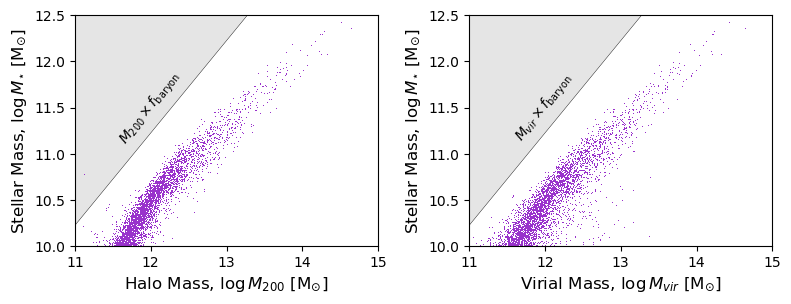

In [19]:
df_cen = df.loc[df['GroupFirstSub']==1]
df_sat = df.loc[df['GroupFirstSub']==0]

mstar = df_cen['SubhaloMassType_stars']
mhalo = df_cen['Group_M_Crit200']
mdyn = df_cen['SubhaloMass']
A = 2
G = 4.301e-9 # Msun^-1 km^2 s^-2 Mpc 
mvir = np.log10(A/G * df_cen['GroupVelDisp']**2 * df_cen['Group_R_Crit200']/1e3)

fig, axarr = plt.subplots(1,2,figsize=(9,3), sharey=False)
fig.subplots_adjust(wspace=0.3)

xmin,xmax = 11,15
ymin,ymax = 10,12.5
baryon_fraction = 0.1675


ax = axarr[0]
# mstar vs m200
ax.scatter(mhalo,mstar,s=0.1,lw=0,ec=None,c='darkorchid',marker='o')
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
ax.set_ylabel('Stellar Mass, $\log M_{\star}$ [M$_{\odot}$]',fontsize=12)
ax.set_xlabel('Halo Mass, $\log M_{200}$ [M$_{\odot}$]',fontsize=12)
# cosmic baryon fraction
ax.plot(
    [xmin,xmax], np.array([xmin,xmax])+np.log10(baryon_fraction),
    ls='solid',c='black',lw=0.3,
)
ax.fill_between(
    [xmin,xmax], y1 = np.array([xmin,xmax])+np.log10(baryon_fraction),
    y2 = [ymax,ymax], fc='black', alpha=0.1, zorder=-1,
)
ax.text(
    12,11.5,'$M_{200}\\times f_{\mathrm{baryon}}$',
    transform=ax.transData,ha='center',va='center', rotation=52,
)

ax = axarr[1]
# mstar vs m200
ax.scatter(mvir,mstar,s=0.1,lw=0,ec=None,c='darkorchid',marker='o')
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
ax.set_ylabel('Stellar Mass, $\log M_{\star}$ [M$_{\odot}$]',fontsize=12)
ax.set_xlabel('Virial Mass, $\log M_{vir}$ [M$_{\odot}$]',fontsize=12)
# cosmic baryon fraction
ax.plot(
    [xmin,xmax], np.array([xmin,xmax])+np.log10(baryon_fraction),
    ls='solid',c='black',lw=0.3,
)
ax.fill_between(
    [xmin,xmax], y1 = np.array([xmin,xmax])+np.log10(baryon_fraction),
    y2 = [ymax,ymax], fc='black', alpha=0.1, zorder=-1,
)
ax.text(
    12,11.5,'$M_{vir}\\times f_{\mathrm{baryon}}$',
    transform=ax.transData,ha='center',va='center', rotation=52,
)

fig.savefig('figures/Mstar_Mhalo_Mvir_TNG100-1.jpg',dpi=256,bbox_inches='tight')

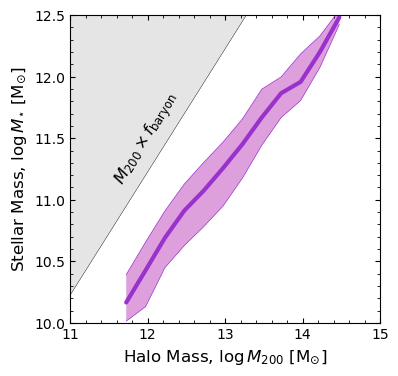

In [83]:
def mstar_mhalo(
    ax, label, mstar, mhalo, 
    scolor='black',lcolor='darkorchid',
    fcolor='plum',fill=False,scatter=False,
):
    
    # mstar vs m200
    if scatter:
        ax.scatter(
            mhalo, mstar, s=0.1, lw=0, ec=None, 
            c=scolor, marker='o'
        )
    nbins = 12
    xedges = np.linspace(11.6,14.6,nbins+1)
    widths= xedges[1:]-xedges[:-1]
    xcs = xedges[:-1]+widths/2

    bin_idxs = np.digitize(mhalo,xedges)-1
    med = np.zeros(nbins)
    pupper = np.zeros(nbins)
    plower = np.zeros(nbins)
    for idx in range(nbins):
        sample = mstar[bin_idxs == idx]
        med[idx] = np.nanmedian(sample)
        pupper[idx] = np.nanpercentile(sample,95)
        plower[idx] = np.nanpercentile(sample,5)

    ax.plot(xcs,med,ls='solid',c=lcolor,lw=3,solid_capstyle='round',label=label)
    ax.plot(xcs,plower,ls='solid',c=lcolor,lw=0.5,solid_capstyle='round')
    ax.plot(xcs,pupper,ls='solid',c=lcolor,lw=0.5,solid_capstyle='round')
    if fill: ax.fill_between(xcs,y1=plower,y2=pupper,fc=fcolor)


fig, ax = plt.subplots(1,1,figsize=(4,4))
xmin,xmax = 11,15
ymin,ymax = 10,12.5
baryon_fraction = 0.1675

ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
ax.set_ylabel('Stellar Mass, $\log M_{\star}$ [M$_{\odot}$]',fontsize=12)
ax.set_xlabel('Halo Mass, $\log M_{200}$ [M$_{\odot}$]',fontsize=12)
# cosmic baryon fraction
ax.plot(
    [xmin,xmax], np.array([xmin,xmax])+np.log10(baryon_fraction),
    ls='solid',c='black',lw=0.3,
)
ax.fill_between(
    [xmin,xmax], y1 = np.array([xmin,xmax])+np.log10(baryon_fraction),
    y2 = [ymax,ymax], fc='black', alpha=0.1, zorder=-1,
)
ax.text(
    12,11.5,'$M_{200}\\times f_{\mathrm{baryon}}$',
    transform=ax.transData,ha='center',va='center', rotation=59, fontsize=12,
)
ax.tick_params(which='both', direction='in', top=True, right=True)
ax.minorticks_on()

# TNG100
df_cen = df.loc[df['GroupFirstSub']==1]
df_sat = df.loc[df['GroupFirstSub']==0]

mstar = df_cen['SubhaloMassType_stars']
mhalo = df_cen['Group_M_Crit200']

mstar_mhalo(
    ax, 'TNG100-1', mstar, mhalo, scolor='black',
    lcolor='darkorchid', fcolor='plum', fill=True,
    scatter=False,
)

fig.savefig('figures/Mstar_Mhalo_Mvir_TNG100-1.jpg',dpi=256,bbox_inches='tight')

/software/setonix/2024.05/software/linux-sles15-zen3/gcc-12.2.0/py-pandas-2.1.2-vqf6vmu7i5w6ld2beg2y5bx35xtpvyw3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


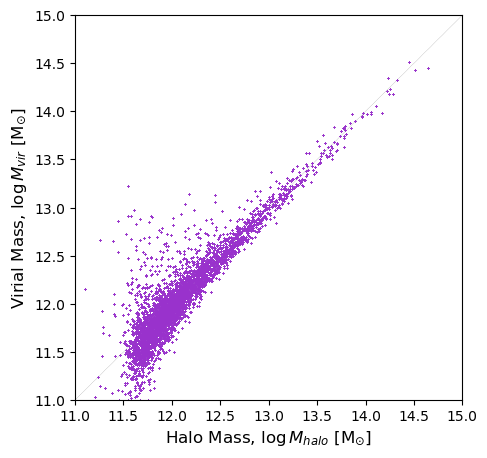

In [165]:
mstar = df_cen['SubhaloMassType_stars']
mhalo = df_cen['Group_M_Crit200']
rhalo = df_cen['Group_R_Crit200']
mdyn = df_cen['SubhaloMass']
xmin,xmax=11.,15.

A = 2
G = 4.301e-9 # Msun^-1 km^2 s^-2 Mpc 
mvir = np.log10(A/G * df_cen['GroupVelDisp_Z']**2 * df_cen['Group_R_Crit200']/1e3)

fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter(mhalo,mvir,s=1,lw=0,ec=None,c='darkorchid',marker='o')
ax.set_xlim(xmin,xmax)
ax.set_ylim(xmin,xmax)
ax.set_xlabel('Halo Mass, $\log M_{halo}$ [M$_{\odot}$]',fontsize=12)
ax.set_ylabel('Virial Mass, $\log M_{vir}$ [M$_{\odot}$]',fontsize=12)
ax.plot([xmin,xmax],[xmin,xmax],ls='dashed',c='black',zorder=-1,lw=0.1)

fig.savefig('figures/Mvir_Mhalo_TNG100.jpg',dpi=256,bbox_inches='tight')

/software/projects/pawsey0119/bottrell/work/Simulations/Scripts/Morphologies/mymysql.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(command, con=connection)
/software/projects/pawsey0119/bottrell/work/Simulations/Scripts/Morphologies/mymysql.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(command, con=connection)
/software/projects/pawsey0119/bottrell/work/Simulations/Scripts/Morphologies/mymysql.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(command, con=c

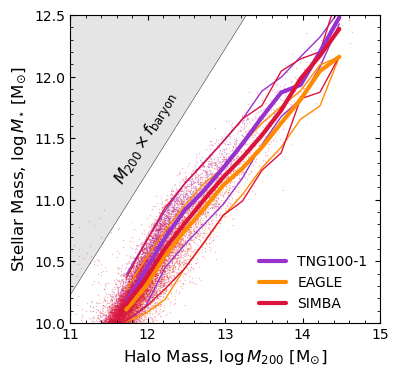

In [17]:
def mstar_mhalo(
    ax, label, mstar, mhalo, 
    scolor='black',lcolor='darkorchid',
    fcolor='plum',fill=False,scatter=False,
    limits = False,
):
    
    # mstar vs m200
    if scatter:
        ax.scatter(
            mhalo, mstar, s=1, lw=0, ec=None, 
            c=scolor, marker='o', alpha=0.3,
            zorder=-1,
        )
    nbins = 12
    xedges = np.linspace(11.6,14.6,nbins+1)
    widths= xedges[1:]-xedges[:-1]
    xcs = xedges[:-1]+widths/2

    bin_idxs = np.digitize(mhalo,xedges)-1
    med = np.zeros(nbins)
    pupper = np.zeros(nbins)
    plower = np.zeros(nbins)
    for idx in range(nbins):
        sample = mstar[bin_idxs == idx]
        med[idx] = np.nanmedian(sample)
        pupper[idx] = np.nanpercentile(sample,95)
        plower[idx] = np.nanpercentile(sample,5)

    ax.plot(xcs,med,ls='solid',c=lcolor,lw=3,solid_capstyle='round',label=label,zorder=1)
    if limits:
        ax.plot(xcs,plower,ls='solid',c=lcolor,lw=1,solid_capstyle='round',zorder=0)
        ax.plot(xcs,pupper,ls='solid',c=lcolor,lw=1,solid_capstyle='round',zorder=0)
    if fill: ax.fill_between(xcs,y1=plower,y2=pupper,fc=fcolor)

    return ax


fig, ax = plt.subplots(1,1,figsize=(4,4))
xmin,xmax = 11,15
ymin,ymax = 10,12.5
baryon_fraction = 0.1675

ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
ax.set_ylabel('Stellar Mass, $\log M_{\star}$ [M$_{\odot}$]',fontsize=12)
ax.set_xlabel('Halo Mass, $\log M_{200}$ [M$_{\odot}$]',fontsize=12)
# cosmic baryon fraction
ax.plot(
    [xmin,xmax], np.array([xmin,xmax])+np.log10(baryon_fraction),
    ls='solid',c='black',lw=0.3,
)
ax.fill_between(
    [xmin,xmax], y1 = np.array([xmin,xmax])+np.log10(baryon_fraction),
    y2 = [ymax,ymax], fc='black', alpha=0.1, zorder=-1,
)
ax.text(
    12,11.5,'$M_{200}\\times f_{\mathrm{baryon}}$',
    transform=ax.transData,ha='center',va='center', rotation=59, fontsize=12,
)
ax.tick_params(which='both', direction='in', top=True, right=True)
ax.minorticks_on()

# TNG50
database='IllustrisTNG50_1'
label='TNG50'
query = [
    'SELECT',
    's.SubhaloMass, s.Group_M_Crit200, s.Group_R_Crit200,',
    's.GroupVelDisp, s.SubhaloMassType_stars, s.GroupFirstSub',
    'FROM Subhalos as s',
    'WHERE s.SnapNum>=91 and s.Snapnum<=91',
    'ORDER BY s.snapnum,s.subfindid',
]
query = ' '.join(query)
df = mymysql.query_df(query, database, cnf_path='~/.mysql/ningaloo.cnf')

df_cen = df.loc[df['GroupFirstSub']==1]
df_sat = df.loc[df['GroupFirstSub']==0]

mstar = df_cen['SubhaloMassType_stars']
mhalo = df_cen['Group_M_Crit200']

ax = mstar_mhalo(
    ax, 'TNG50', mstar, mhalo, scolor='mediumblue',
    lcolor='mediumblue', fcolor='royalblue', fill=False,
    scatter=True, limits=True
)

# TNG100
database='TNG100_1'
label='TNG100'
query = [
    'SELECT',
    's.SubhaloMass, s.Group_M_Crit200, s.Group_R_Crit200,',
    's.GroupVelDisp, s.SubhaloMassType_stars, s.GroupFirstSub',
    'FROM Subhalos as s',
    'WHERE s.SnapNum>=91 and s.Snapnum<=91',
    'ORDER BY s.snapnum,s.subfindid',
]
query = ' '.join(query)
df = mymysql.query_df(query, database, cnf_path='~/.mysql/ningaloo.cnf')

df_cen = df.loc[df['GroupFirstSub']==1]
df_sat = df.loc[df['GroupFirstSub']==0]

mstar = df_cen['SubhaloMassType_stars']
mhalo = df_cen['Group_M_Crit200']

ax = mstar_mhalo(
    ax, 'TNG100', mstar, mhalo, scolor='darkorchid',
    lcolor='darkorchid', fcolor='plum', fill=False,
    scatter=True, limits=True
)

# Eagle
database='Eagle100_1'
label='EAGLE'
query = [
    'SELECT',
    's.SubhaloMass, s.Group_M_Crit200, s.Group_R_Crit200,',
    's.GroupVelDisp, s.SubhaloMassType_stars, s.GroupFirstSub',
    'FROM Subhalos as s',
    'WHERE s.SnapNum>=27 and s.Snapnum<=27',
    'ORDER BY s.snapnum,s.subfindid',
]
query = ' '.join(query)
df = mymysql.query_df(query, database, cnf_path='~/.mysql/ningaloo.cnf')

df_cen = df.loc[df['GroupFirstSub']==1]
df_sat = df.loc[df['GroupFirstSub']==0]

mstar = df_cen['SubhaloMassType_stars']
mhalo = df_cen['Group_M_Crit200']

ax = mstar_mhalo(
    ax, label, mstar, mhalo, scolor='darkorange',
    lcolor='darkorange', fcolor='orange', fill=False,
    scatter=True, limits=True
)

# SIMBA
database='Simba100_1'
label='SIMBA'
query = [
    'SELECT',
    's.SubhaloMass, s.Group_M_Crit200, s.Group_R_Crit200,',
    's.GroupVelDisp, s.SubhaloMassType_stars, s.GroupFirstSub',
    'FROM Subhalos as s',
    'WHERE s.SnapNum>=145 and s.Snapnum<=145',
    'ORDER BY s.snapnum,s.subfindid',
]
query = ' '.join(query)
df = mymysql.query_df(query, database, cnf_path='~/.mysql/ningaloo.cnf')

df_cen = df.loc[df['GroupFirstSub']==1]
df_sat = df.loc[df['GroupFirstSub']==0]

mstar = df_cen['SubhaloMassType_stars']
mhalo = df_cen['Group_M_Crit200']

ax = mstar_mhalo(
    ax, label, mstar, mhalo, scolor='crimson',
    lcolor='crimson', fcolor='orangered', fill=False,
    scatter=True, limits =True
)

ax.legend(loc=4,edgecolor='None')
fig.savefig('figures/Mvir_Mhalo.png', dpi=256, bbox_inches='tight')

/software/projects/pawsey0119/bottrell/work/Simulations/Scripts/Morphologies/mymysql.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(command, con=connection)
/software/projects/pawsey0119/bottrell/work/Simulations/Scripts/Morphologies/mymysql.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(command, con=connection)


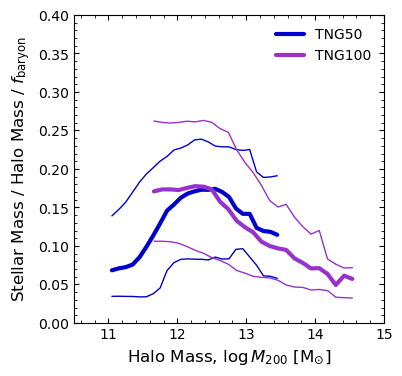

In [68]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
xmin,xmax = 10.5,15
ymin,ymax = 0,0.3

ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
ax.set_ylabel('Stellar Mass / Halo Mass / $f_{\mathrm{baryon}}$',fontsize=12)
ax.set_xlabel('Halo Mass, $\log M_{200}$ [M$_{\odot}$]',fontsize=12)
ax.tick_params(which='both', direction='in', top=True, right=True)
ax.minorticks_on()

def shmr(
    ax, label, mstar, mhalo, 
    scolor='black',lcolor='darkorchid',
    fcolor='plum',fill=False,scatter=False,
    limits = False, kernel_size=0.2, nbins=100,
):

    baryon_fraction = 0.1675
    shmr = 10**(mstar-mhalo)/baryon_fraction
    if scatter:
        ax.scatter(
            mhalo, shmr, s=1, lw=0, ec=None, 
            c=scolor, marker='o', alpha=0.3, zorder=-1,
        )

    if label=='TNG50':
        xmin,xmax = 11,13.5
    else:
        xmin,xmax = 11.6,14.6
    
    xedges = np.linspace(xmin,xmax,nbins+1)
    widths = xedges[1:]-xedges[:-1]
    xcs = xedges[:-1]+widths/2

    meds = np.zeros(nbins)
    plower = np.zeros(nbins)
    pupper = np.zeros(nbins)
    for j,xc in enumerate(xcs):
        mask = (mhalo>=xc-kernel_size) * (mhalo<(xc+kernel_size))
        meds[j] = np.nanmedian(shmr[mask])
        pupper[j] = np.nanpercentile(shmr[mask],95)
        plower[j] = np.nanpercentile(shmr[mask],5)

    ax.plot(xcs,meds,ls='solid',c=lcolor,lw=3,solid_capstyle='round',label=label,zorder=1)
    if limits:
        ax.plot(xcs,plower,ls='solid',c=lcolor,lw=1,solid_capstyle='round',zorder=0)
        ax.plot(xcs,pupper,ls='solid',c=lcolor,lw=1,solid_capstyle='round',zorder=0)
    if fill: ax.fill_between(xcs,y1=plower,y2=pupper,fc=fcolor)

    
    return ax

# TNG50
database='IllustrisTNG50_1'
label='TNG50'
query = [
    'SELECT',
    's.SubhaloMass, s.Group_M_Crit200, s.Group_R_Crit200,',
    's.GroupVelDisp, s.SubhaloMassType_stars, s.GroupFirstSub',
    'FROM Subhalos as s',
    'WHERE s.SnapNum>=91 and s.Snapnum<=91',
    'ORDER BY s.snapnum,s.subfindid',
]
query = ' '.join(query)
df = mymysql.query_df(query, database, cnf_path='~/.mysql/ningaloo.cnf')
df_cen = df.loc[df['GroupFirstSub']==1]
df_sat = df.loc[df['GroupFirstSub']==0]
mstar = df_cen['SubhaloMassType_stars']+np.log10(1/1.5)
mhalo = df_cen['Group_M_Crit200']
ax = shmr(
    ax, label, mstar, mhalo, scolor='mediumblue',
    lcolor='mediumblue', fcolor='royalblue', fill=False,
    scatter=False, limits =True, kernel_size=0.4, nbins=25
)


# TNG100
database='TNG100_1'
label='TNG100'
query = [
    'SELECT',
    's.SubhaloMass, s.Group_M_Crit200, s.Group_R_Crit200,',
    's.GroupVelDisp, s.SubhaloMassType_stars, s.GroupFirstSub',
    'FROM Subhalos as s',
    'WHERE s.SnapNum>=91 and s.Snapnum<=91',
    'ORDER BY s.snapnum,s.subfindid',
]
query = ' '.join(query)
df = mymysql.query_df(query, database, cnf_path='~/.mysql/ningaloo.cnf')
df_cen = df.loc[df['GroupFirstSub']==1]
df_sat = df.loc[df['GroupFirstSub']==0]
mstar = df_cen['SubhaloMassType_stars']
mhalo = df_cen['Group_M_Crit200']
ax = shmr(
    ax, label, mstar, mhalo, scolor='darkorchid',
    lcolor='darkorchid', fcolor='plum', fill=False,
    scatter=False, limits =True, kernel_size=0.4, nbins=25
)

# # EAGLE
# database='Eagle100_1'
# label='EAGLE'
# query = [
#     'SELECT',
#     's.SubhaloMass, s.Group_M_Crit200, s.Group_R_Crit200,',
#     's.GroupVelDisp, s.SubhaloMassType_stars, s.GroupFirstSub',
#     'FROM Subhalos as s',
#     'WHERE s.SnapNum>=27 and s.Snapnum<=27',
#     'ORDER BY s.snapnum,s.subfindid', 
# ]
# query = ' '.join(query)
# df = mymysql.query_df(query, database, cnf_path='~/.mysql/ningaloo.cnf')
# df_cen = df.loc[df['GroupFirstSub']==1]
# df_sat = df.loc[df['GroupFirstSub']==0]
# mstar = df_cen['SubhaloMassType_stars']
# mhalo = df_cen['Group_M_Crit200']
# ax = shmr(
#     ax, label, mstar, mhalo, scolor='darkorange',
#     lcolor='darkorange', fcolor='orange', fill=False,
#     scatter=False, limits=True, kernel_size=0.4, nbins=25
# )

# # SIMBA
# database='Simba100_1'
# label='SIMBA'
# query = [
#     'SELECT',
#     's.SubhaloMass, s.Group_M_Crit200, s.Group_R_Crit200,',
#     's.GroupVelDisp, s.SubhaloMassType_stars, s.GroupFirstSub',
#     'FROM Subhalos as s',
#     'WHERE s.SnapNum>=145 and s.Snapnum<=145',
#     'ORDER BY s.snapnum,s.subfindid',
# ]
# query = ' '.join(query)
# df = mymysql.query_df(query, database, cnf_path='~/.mysql/ningaloo.cnf')
# df_cen = df.loc[df['GroupFirstSub']==1]
# df_sat = df.loc[df['GroupFirstSub']==0]
# mstar = df_cen['SubhaloMassType_stars']
# mhalo = df_cen['Group_M_Crit200']
# ax = shmr(
#     ax, label, mstar, mhalo, scolor='crimson',
#     lcolor='crimson', fcolor='orangered', fill=False,
#     scatter=False, limits =True, kernel_size=0.4, nbins=25,
# )

ax.legend(loc=1,edgecolor='None')
fig.savefig('figures/SHMR.png', dpi=256, bbox_inches='tight')

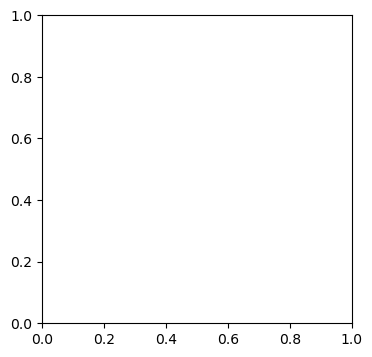

In [69]:
fig, ax = plt.subplots(1,1,figsize=(4,4))
xmin,xmax = 9,12.6


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import mymysql
import pandas as pd
rc('font',**{'family':'sans-serif',})
labelsize=12
ticksize=12
legendsize=10

simulations = [
    ('Eagle','Eagle100-1','Eagle100_1','EAGLE'),
    ('Simba','Simba100-1','Simba100_1','SIMBA'),
    ('IllustrisTNG','TNG100-1','TNG100_1','TNG100'),
    ('IllustrisTNG','TNG50-1','IllustrisTNG50_1','TNG50'),
]

In [37]:
import pymysql

def query_df(command,database,cnf_path):
    '''Query database and return results as dataframe.'''
    connection = pymysql.connect(
        database=database,
        read_default_file=cnf_path,
    )
    df = pd.read_sql(command, con=connection)
    connection.close()
    #df = _df_nullint(df)
    return df

dbcmd = [
    'SELECT s.*, m.*',
    'FROM Subhalos as s JOIN Morphologies_ProFit_HSC_Sersic as m',
    'ON s.snapnum=m.snapnum AND s.subfindid=m.subfindid',
    'WHERE s.SubhaloMassType_stars>=9 and s.snapnum=91',
    'ORDER BY s.snapnum,s.subfindid,m.camera,m.band',
]

df = query_df(' '.join(dbcmd), database='IllustrisTNG50_1',cnf_path='/home/bottrell/.mysql/ningaloo.cnf')

/tmp/ipykernel_2883551/2564729373.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(command, con=connection)


In [38]:
df

,dbID,SnapNum,SubfindID,SubhaloMassType_stars,SubhaloMassType_gas,SubhaloMassType_dm,SubhaloMassInRadType_stars,SubhaloMassInRadType_gas,SubhaloMassInRadType_dm,SubhaloHalfMassRadType_stars,...,SmoothnessBkgDens,Gini,M20,SB1kpc,ResidualAsymmetry_xcen,ResidualAsymmetry_ycen,ResidualAsymmetry,ResidualAsymmetryNoAperture_xcen,ResidualAsymmetryNoAperture_ycen,ResidualAsymmetryNoAperture
0,91_0,91,0,12.73420,13.3625,14.24150,12.55840,11.4677,12.962,43.997500,...,0.000243,0.784958,1.989980,17.2326,784.7500,784.7830,0.197812,790.7440,795.2500,0.301813
1,91_0,91,0,12.73420,13.3625,14.24150,12.55840,11.4677,12.962,43.997500,...,0.000465,0.798986,1.738620,15.0627,784.8880,785.0840,0.190801,785.6180,785.2500,0.280969
2,91_0,91,0,12.73420,13.3625,14.24150,12.55840,11.4677,12.962,43.997500,...,0.000391,0.792609,1.219250,16.1692,784.7500,784.7740,0.188808,790.2500,796.2500,0.286763
3,91_0,91,0,12.73420,13.3625,14.24150,12.55840,11.4677,12.962,43.997500,...,0.001552,0.796882,1.663450,15.3850,784.7500,784.7500,0.163589,784.7510,785.2500,0.237022
4,91_0,91,0,12.73420,13.3625,14.24150,12.55840,11.4677,12.962,43.997500,...,0.000759,0.801650,1.614080,14.9156,784.8350,784.8650,0.178804,784.3200,785.2110,0.256527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60935,91_897490,91,897490,9.09552,-99.0000,6.13393,8.98602,-99.0000,-99.000,0.208566,...,0.000205,0.713586,-1.527860,22.3164,78.2379,78.2500,0.006913,77.7500,78.2500,0.004657
60936,91_897490,91,897490,9.09552,-99.0000,6.13393,8.98602,-99.0000,-99.000,0.208566,...,0.000000,0.847734,-0.932603,20.2984,78.0100,77.9170,0.009192,78.0782,77.8660,0.038524
60937,91_897490,91,897490,9.09552,-99.0000,6.13393,8.98602,-99.0000,-99.000,0.208566,...,0.000000,0.788360,-1.255190,20.9605,78.2626,78.6833,0.017233,80.2500,75.7940,0.024758
60938,91_897490,91,897490,9.09552,-99.0000,6.13393,8.98602,-99.0000,-99.000,0.208566,...,0.001346,0.697434,-0.957252,20.6256,88.7609,78.2500,-0.029201,84.7663,85.2500,-0.038263


In [39]:
df.loc[:, ~df.columns.duplicated()].to_csv('catalogues/HaloFlow_TNG50-1.csv')

In [35]:
df

,DatabaseID,SnapNum,SubfindID,SubhaloMassType_stars,SubhaloMassType_gas,SubhaloMassType_dm,SubhaloMassInRadType_stars,SubhaloMassInRadType_gas,SubhaloMassInRadType_dm,SubhaloHalfMassRadType_stars,...,SmoothnessBkgDens,Gini,M20,SB1kpc,ResidualAsymmetry_xcen,ResidualAsymmetry_ycen,ResidualAsymmetry,ResidualAsymmetryNoAperture_xcen,ResidualAsymmetryNoAperture_ycen,ResidualAsymmetryNoAperture
0,091.0,91,0,12.3589,13.7299,14.5071,12.17920,12.6068,13.6815,135.38200,...,0.000214,0.767125,2.486420,24.8521,994.750,938.245,1.963680,994.750,938.244,2.028670
1,091.0,91,0,12.3589,13.7299,14.5071,12.17920,12.6068,13.6815,135.38200,...,0.000393,0.753043,3.052140,23.6655,1058.280,970.250,8.555630,1058.250,970.750,8.518910
2,091.0,91,0,12.3589,13.7299,14.5071,12.17920,12.6068,13.6815,135.38200,...,0.000372,0.751110,2.859460,24.1255,976.750,935.261,7.157460,976.277,935.750,7.164990
3,091.0,91,0,12.3589,13.7299,14.5071,12.17920,12.6068,13.6815,135.38200,...,0.001882,0.740310,3.127310,23.1739,975.254,934.750,6.885200,975.256,934.750,6.880980
4,091.0,91,0,12.3589,13.7299,14.5071,12.17920,12.6068,13.6815,135.38200,...,0.000855,0.754840,3.136820,23.5458,1027.250,962.249,8.371340,1018.250,955.238,8.440760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126975,091.654791,91,654791,10.0024,-99.0000,10.8658,9.87705,-99.0000,10.1540,3.55856,...,0.000201,0.679124,-1.178790,22.3405,106.750,120.741,-0.006975,106.765,116.750,-0.019377
126976,091.654791,91,654791,10.0024,-99.0000,10.8658,9.87705,-99.0000,10.1540,3.55856,...,0.000358,0.740328,-0.652937,20.8100,110.251,111.250,-0.019359,101.250,122.250,-0.017151
126977,091.654791,91,654791,10.0024,-99.0000,10.8658,9.87705,-99.0000,10.1540,3.55856,...,0.000273,0.721542,-0.799122,21.4472,111.250,113.247,0.012149,111.250,111.747,-0.001698
126978,091.654791,91,654791,10.0024,-99.0000,10.8658,9.87705,-99.0000,10.1540,3.55856,...,0.001601,0.632852,-0.615074,20.6049,117.727,111.236,-0.011981,117.759,111.252,-0.025777


In [ ]:
df_corr = 